检查计算指标时的图像和标注是否正确

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [22]:
inputs = torch.load('/root/mmyolo/work_dirs/outputs/0725_tensor/inputs.pt')
assigned_bboxes = torch.load('/root/mmyolo/work_dirs/outputs/0725_tensor/assigned_bboxes.pt')
assigned_scores = torch.load('/root/mmyolo/work_dirs/outputs/0725_tensor/assigned_scores.pt')
fg_prior = torch.load('/root/mmyolo/work_dirs/outputs/0725_tensor/fg_mask_pre_prior.pt')

In [23]:
# 取出inputs中的一张图片和对应的assigned
idx = 0
image = inputs[idx].permute(1, 2, 0).cpu()
image_assigned_bboxes = assigned_bboxes[idx].cpu()
image_assigned_scores = assigned_scores[idx].cpu()
image_fg_prior = fg_prior[idx].cpu()

In [24]:
# 取正样本的bboxes
# image_fg_prior表示那些anchors在gt内
prior_bbox_mask = image_fg_prior.unsqueeze(-1).repeat([1, 4])
# 取出在gt内的anchor对应的gt_bboxes
pred_bboxes_pos = torch.masked_select(image_assigned_bboxes, prior_bbox_mask).reshape([-1, 4])

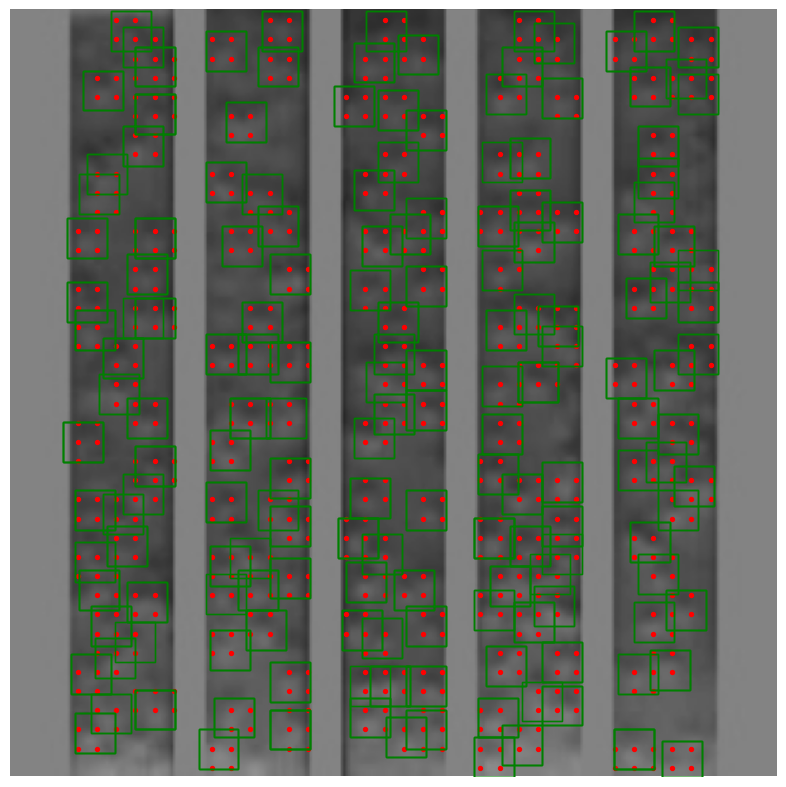

In [25]:
# 设置画布
mydpi = 96
plt.figure(figsize=(8, 8), dpi=mydpi)
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)  

ax = plt.gca()
plt.imshow(image)

import torch.nn.functional as F
# 画落在GT框中的预设锚点
# 锚点尺寸(40,40)怎么还原到图像尺寸(320,320)
image_fg_prior = image_fg_prior.float().reshape(40, 40)
image_pos_anchor = torch.zeros(320, 320)
indices = torch.nonzero(image_fg_prior)
for idx in indices:
    x, y = idx[0], idx[1]
    upsampled_x, upsampled_y = x * 8 + 4, y * 8 + 4
    image_pos_anchor[upsampled_x, upsampled_y] = 1

pos_indexes = torch.nonzero(image_pos_anchor == 1)
x, y = pos_indexes[:, 1], pos_indexes[:, 0]


# 画对应正样本位置的预测框
plt.scatter(x, y, marker='.', color='r')
for bb in pred_bboxes_pos:
    x1, y1, x2, y2 = bb
    ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='green', facecolor=(0,0,0,0), lw=1))
plt.show()  

In [26]:
inputs = torch.load('/root/mmyolo/work_dirs/outputs/inputs.pt')
inputs_tensors = torch.load('/root/mmyolo/work_dirs/outputs/output_tensor.pt')
assigned_bboxes = inputs_tensors['assigned_bboxes']
assigned_scores = inputs_tensors['assigned_scores']
flatten_pred_bboxes = inputs_tensors['flatten_pred_bboxes']
gt_bboxes = inputs_tensors['gt_bboxes']
pad_bbox_flag = inputs_tensors['pad_bbox_flag']
fg_prior = inputs_tensors['fg_mask_pre_prior']

In [27]:
idx = 0
image = inputs[idx].permute(1, 2, 0).cpu()
image_assigned_bboxes = assigned_bboxes[idx].cpu()
image_pred_bboxes = flatten_pred_bboxes[idx].cpu()
image_gt_bboxes = gt_bboxes[idx].cpu()
image_scores = assigned_scores[idx].cpu()
image_fg_prior = fg_prior[idx].cpu()
image_pad_bbox_flag = pad_bbox_flag[idx].cpu()

prior_bbox_mask = image_fg_prior.unsqueeze(-1).repeat([1, 4])
pred_bboxes = torch.masked_select(image_pred_bboxes, prior_bbox_mask).reshape([-1, 4])
pred_scores = torch.masked_select(image_scores.sum(-1), image_fg_prior)

image_pad_bbox_flag = image_pad_bbox_flag.repeat([1, 4]).bool()
image_gt_bboxes = torch.masked_select(image_gt_bboxes, image_pad_bbox_flag).reshape([-1, 4])

In [28]:
# 按pred_score>0.3筛选出pred_bboxes
pred_score_thr = (pred_scores > 0.3)
pred_bboxes = pred_bboxes[pred_score_thr]
pred_scores = pred_scores[pred_score_thr]

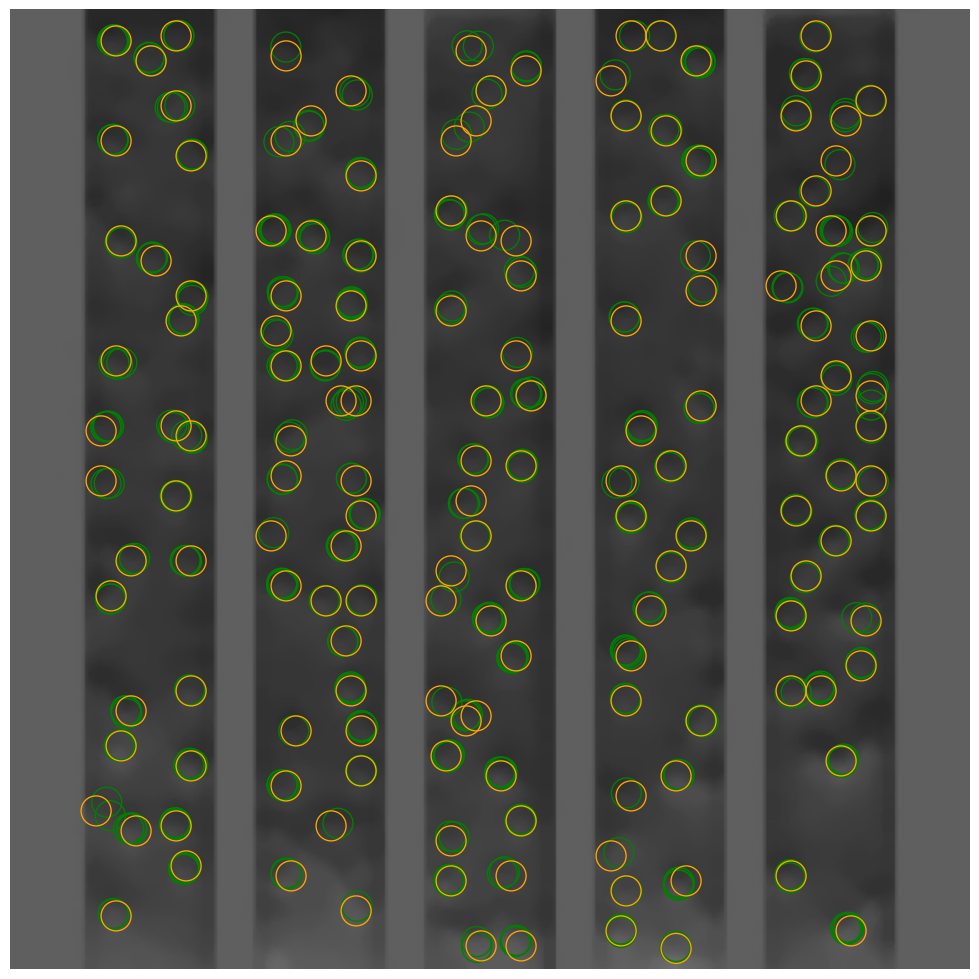

In [29]:
# 设置画布
mydpi = 96
plt.figure(figsize=(10, 10), dpi=mydpi)
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)  

plt.imshow(image)

def show_bbox(bboxes, color):
    for bb in bboxes:
        x1, y1, x2, y2 = bb
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        plt.gca().add_patch(plt.Circle((cx, cy), 5, edgecolor=color, facecolor=(0,0,0,0), lw=1))
        # plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor=color, facecolor=(0,0,0,0), lw=1))

image_random_box = torch.randint(0, 320, (100, 4))
show_bbox(pred_bboxes.detach(), 'green')
show_bbox(image_gt_bboxes, 'orange')

plt.show()